In [15]:
import numpy as np
import pandas as pd
import plotly 

import matplotlib.pyplot as plt
import matplotlib as mpl

from opentisim import hydrogen_objects
from opentisim import hydrogen_defaults
from opentisim import hydrogen_system

from opentisim import core
from opentisim import plot

# plotly.tools.set_credentials_file(username='stephh', api_key='aYheUBjQH0kyWL5yo9E6')

# 0. Prepare inputs

In [2]:
startyear = 2019
lifecycle = 10

## 0.1 Generate demand forecast scenario

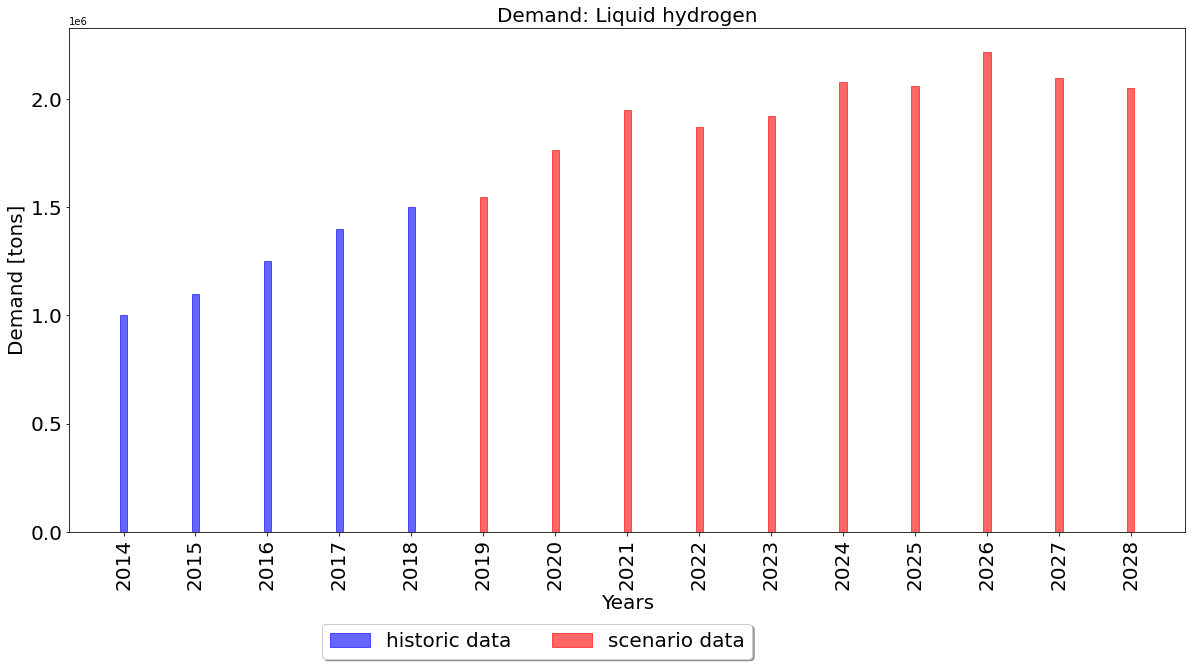

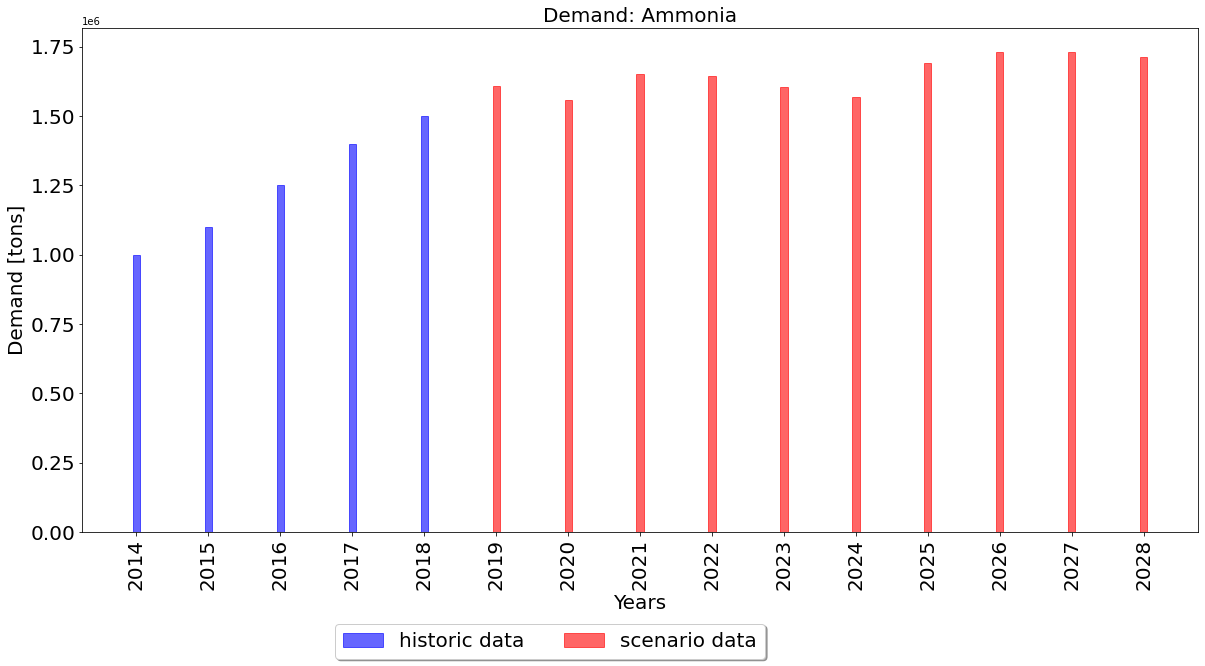

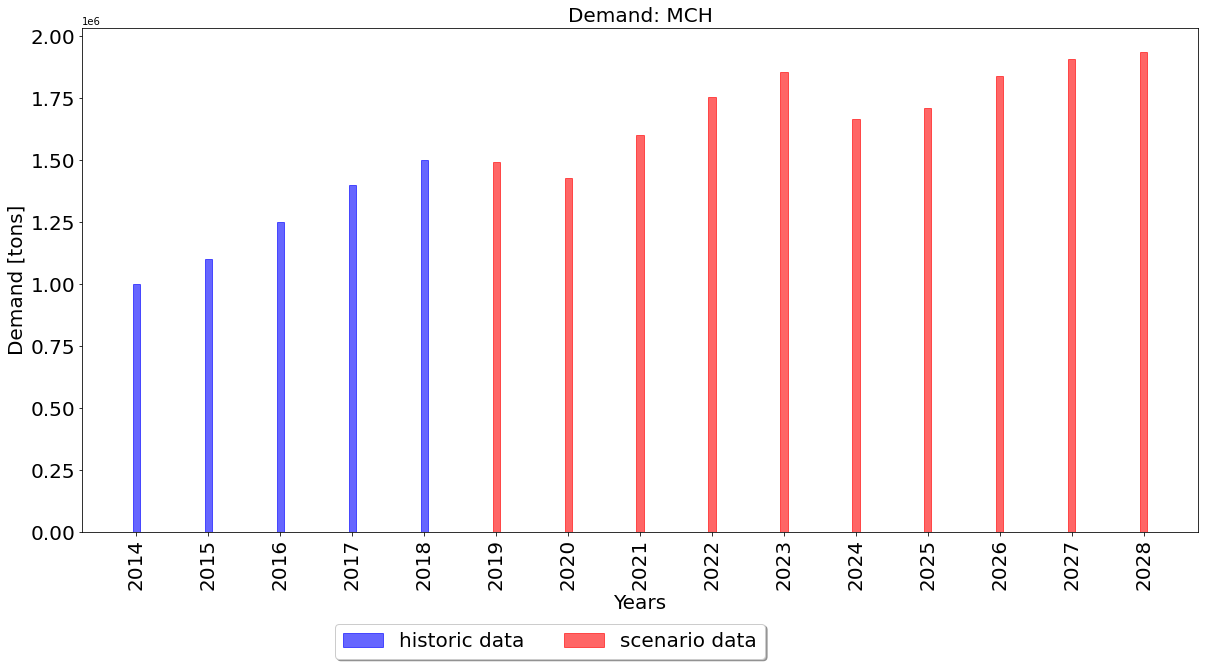

In [3]:
scenario = 'random' #choice between permanent or random

if scenario == 'random': 
    # instantiate a commodity object
    lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_lhydrogen_data)
    ammonia = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_ammonia_data)
    MCH = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_MCH_data)

    # create a future througput scenario
    lhydrogen.scenario_random(startyear = startyear, lifecycle = lifecycle)
    ammonia.scenario_random(startyear = startyear, lifecycle = lifecycle)
    MCH.scenario_random(startyear = startyear, lifecycle = lifecycle)

    demand = [ammonia]

    # plot scenarios 
    if True:
        lhydrogen.plot_demand()
        ammonia.plot_demand()
        MCH.plot_demand()
else: 
    years = list(range(startyear, startyear+lifecycle))

    demand = []
    for year in years: 
        if year < 2024: 
            demand.append(100000)
        else: 
            demand.append(300000)

    scenario_data={'year': years, 'volume': demand}

    # instantiate a commodity objects
    lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_lhydrogen_data)
    lhydrogen.scenario_data = pd.DataFrame(data=scenario_data)

    # Ammonia
    hydrogen_defaults.commodity_ammonia_data['historic_data'] = []
    hydrogen_defaults.commodity_ammonia_data['scenario_data'] = []
    ammonia = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_ammonia_data)

    # MCH
    hydrogen_defaults.commodity_MCH_data['historic_data'] = []
    hydrogen_defaults.commodity_MCH_data['scenario_data'] = []
    MCH = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_MCH_data)

    # combine
    demand = [lhydrogen, ammonia, MCH]

    # plot scenarios 
    if False:
        lhydrogen.plot_demand()
        ammonia.plot_demand()
        MCH.plot_demand()

## 0.2 Generate vessels

In [4]:
# instantiate vessels
Smallhydrogen = hydrogen_objects.Vessel(**hydrogen_defaults.smallhydrogen_data)
Largehydrogen = hydrogen_objects.Vessel(**hydrogen_defaults.largehydrogen_data)
Smallammonia = hydrogen_objects.Vessel(**hydrogen_defaults.smallammonia_data)
Largeammonia = hydrogen_objects.Vessel(**hydrogen_defaults.largeammonia_data)
Handysize = hydrogen_objects.Vessel(**hydrogen_defaults.handysize_data)
Panamax = hydrogen_objects.Vessel(**hydrogen_defaults.panamax_data)
VLCC = hydrogen_objects.Vessel(**hydrogen_defaults.vlcc_data)


vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

# 1. Instantiate terminal system

In [5]:
Terminal = hydrogen_system.System(startyear = startyear, 
                         lifecycle = lifecycle, 
                         elements = demand + vessels, 
                         operational_hours = 5840,   # example Wijnand
                         debug=False)

   year   volume
0  2019  1606512
1  2020  1557626
2  2021  1650211
3  2022  1645799
4  2023  1604208
5  2024  1568121
6  2025  1690453
7  2026  1729149
8  2027  1730809
9  2028  1713547


60

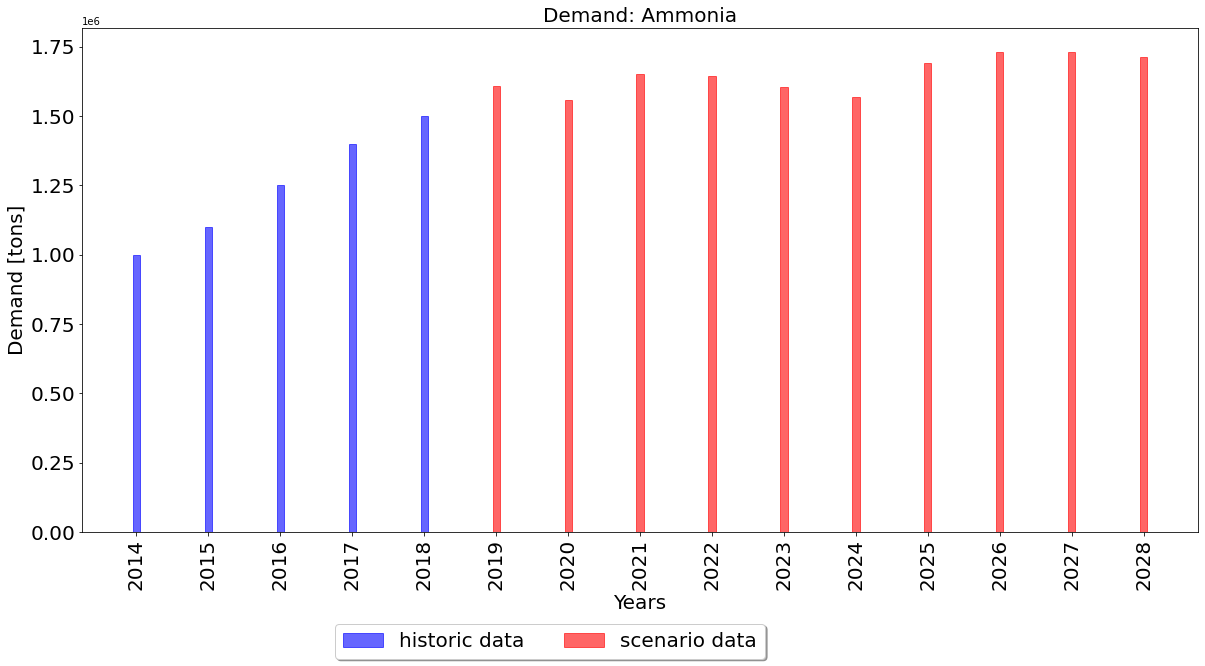

In [6]:
print(Terminal.elements[0].scenario_data)
Terminal.elements[0].plot_demand()
Terminal.elements[0].largeammonia_perc

In [7]:
Terminal.elements[0].__dict__

{'historic_data':    year   volume
 0  2014  1000000
 1  2015  1100000
 2  2016  1250000
 3  2017  1400000
 4  2018  1500000,
 'scenario_data':    year   volume
 0  2019  1606512
 1  2020  1557626
 2  2021  1650211
 3  2022  1645799
 4  2023  1604208
 5  2024  1568121
 6  2025  1690453
 7  2026  1729149
 8  2027  1730809
 9  2028  1713547,
 'type': 'Ammonia',
 'handling_fee': 150,
 'smallhydrogen_perc': 0,
 'largehydrogen_perc': 0,
 'smallammonia_perc': 40,
 'largeammonia_perc': 60,
 'handysize_perc': 0,
 'panamax_perc': 0,
 'vlcc_perc': 0,
 'name': 'Ammonia',
 'id': 'a2992e77-0590-11eb-9950-8c04ba0c9d8f'}

# 2. Start simulation
Develop terminal given the throughput scenario and investment triggers implemented

In [8]:
Terminal.simulate()

c:\users\mrv\onedrive - van oord\software\github\opentisim\opentisim\hydrogen_system.py:200: RuntimeWarning: invalid value encountered in double_scalars
  waiting_time_occupancy = waiting_time_hours * total_calls / self.operational_hours
c:\users\mrv\onedrive - van oord\software\github\opentisim\opentisim\hydrogen_system.py:700: RuntimeWarning: invalid value encountered in double_scalars
  waiting_time_occupancy = waiting_time_hours * total_calls / self.operational_hours
c:\users\mrv\onedrive - van oord\software\github\opentisim\opentisim\hydrogen_system.py:700: RuntimeWarning: invalid value encountered in double_scalars
  waiting_time_occupancy = waiting_time_hours * total_calls / self.operational_hours


## Report all elements

In [9]:
if False: 
    for element in Terminal.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__)

In [10]:
# Terminal.add_cashflow_elements()

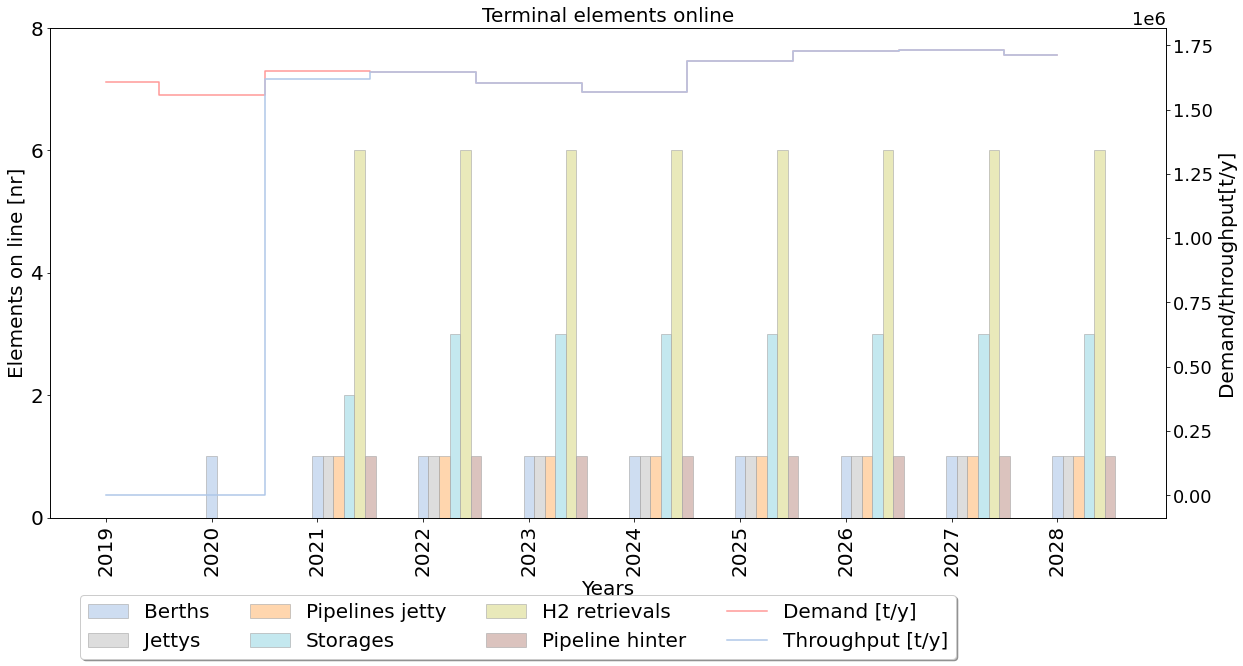

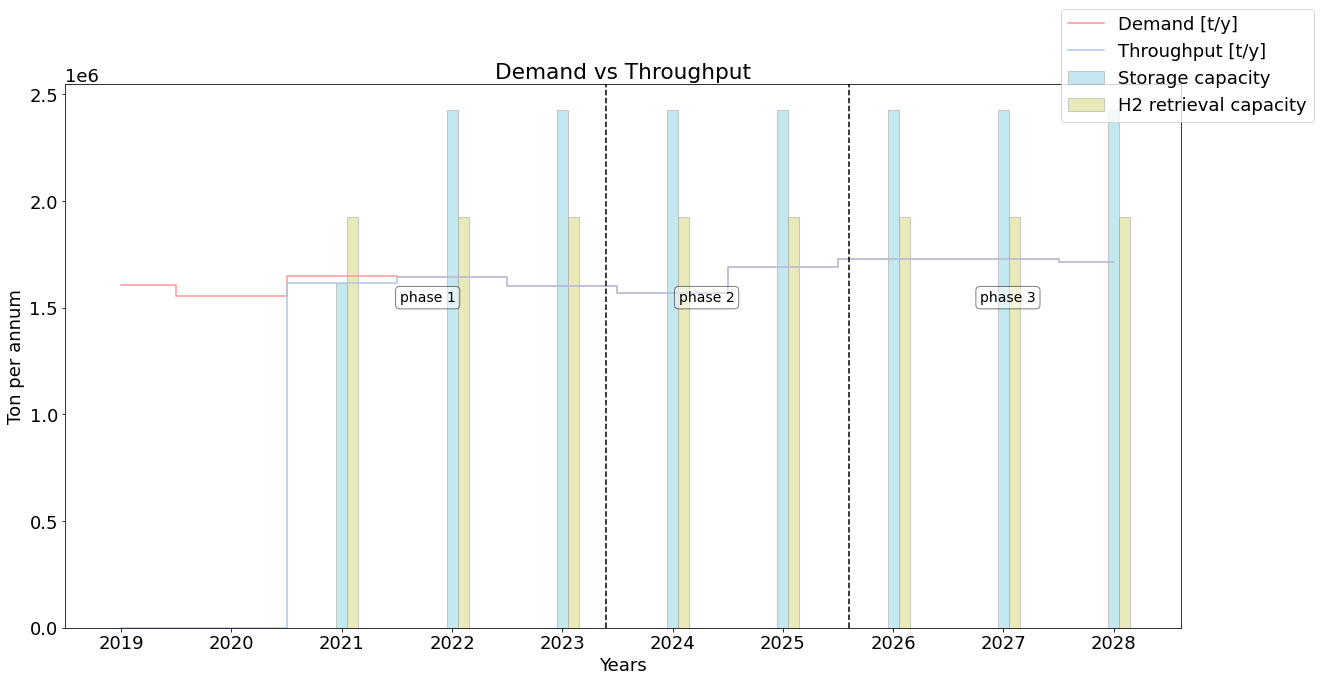

In [11]:
Terminal.terminal_elements_plot()
Terminal.demand_terminal_plot()

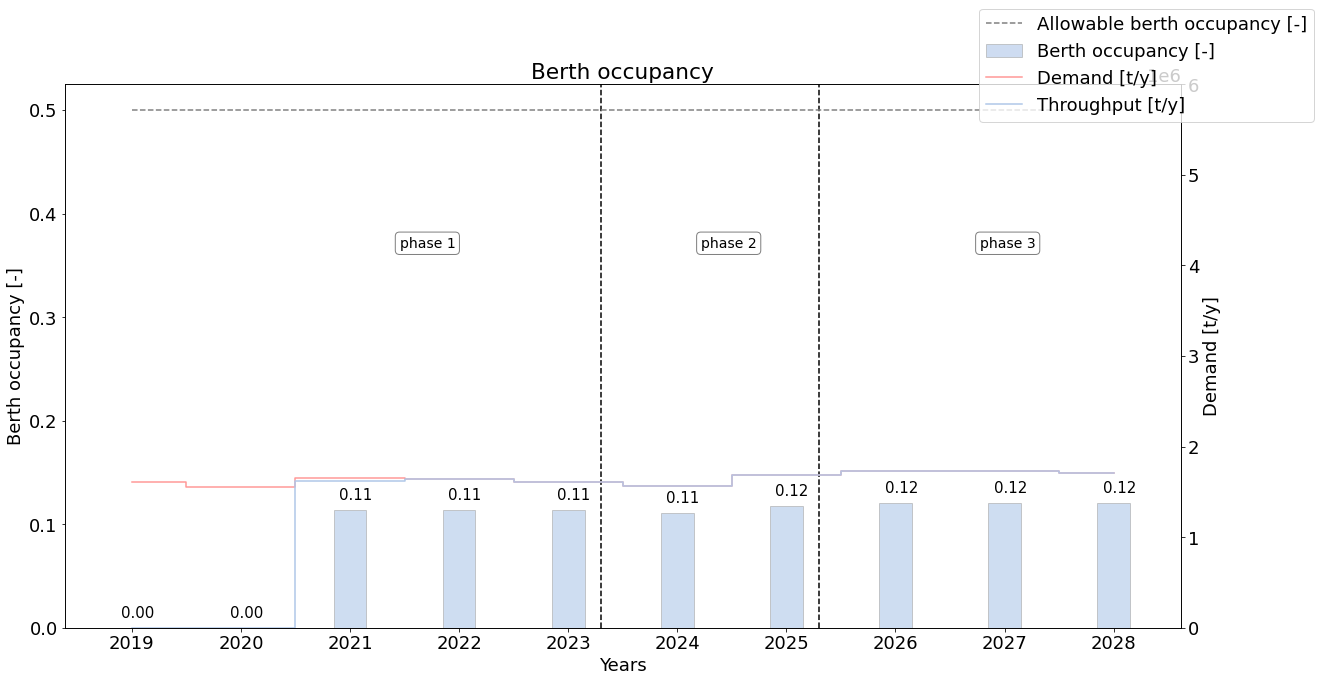

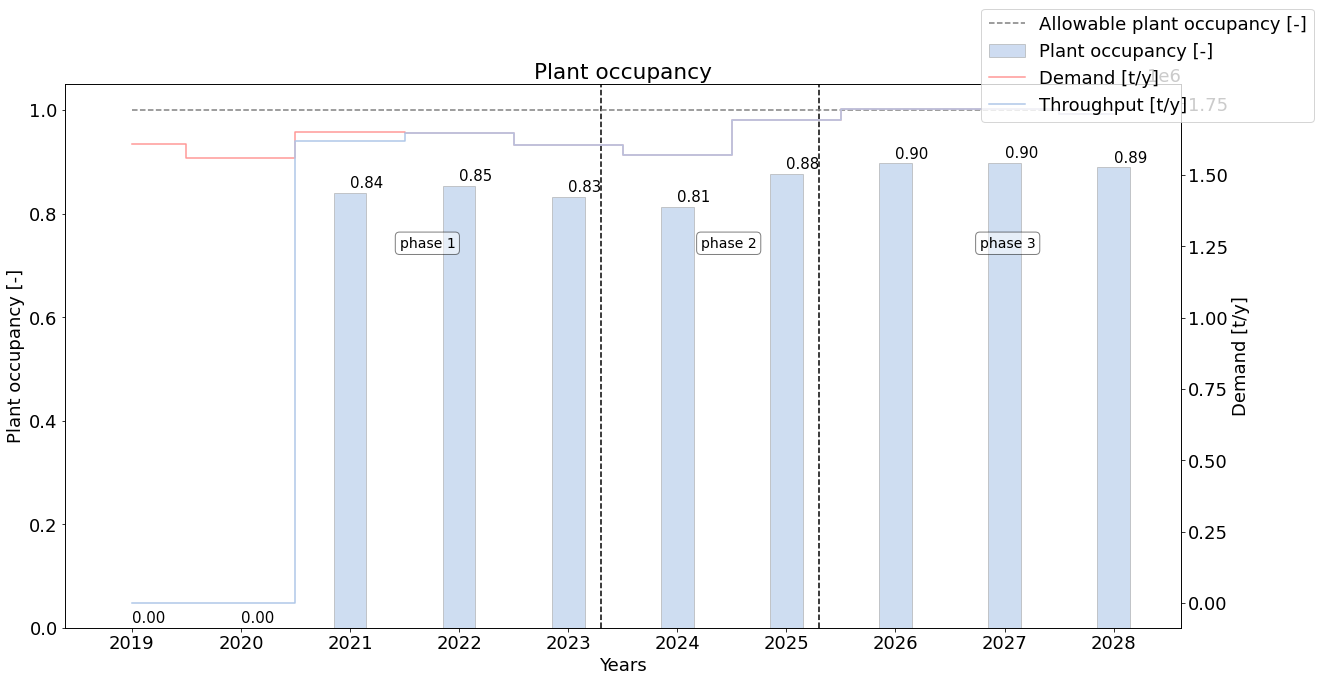

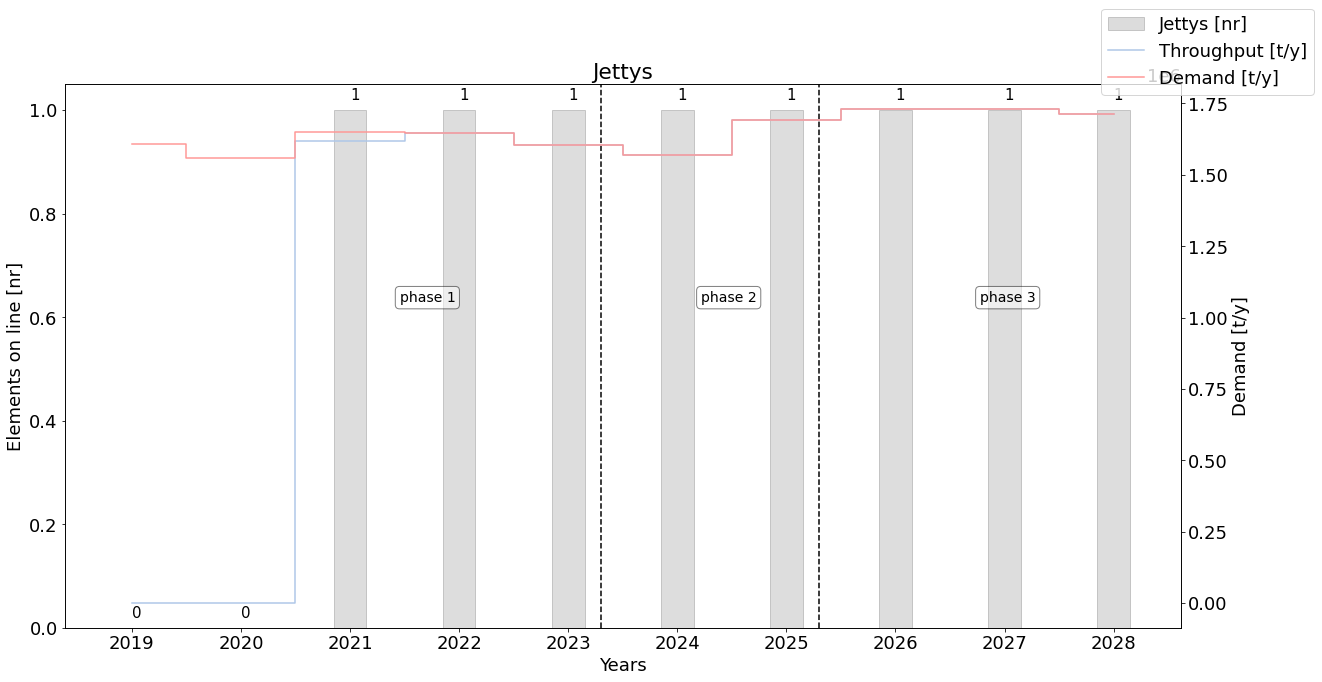

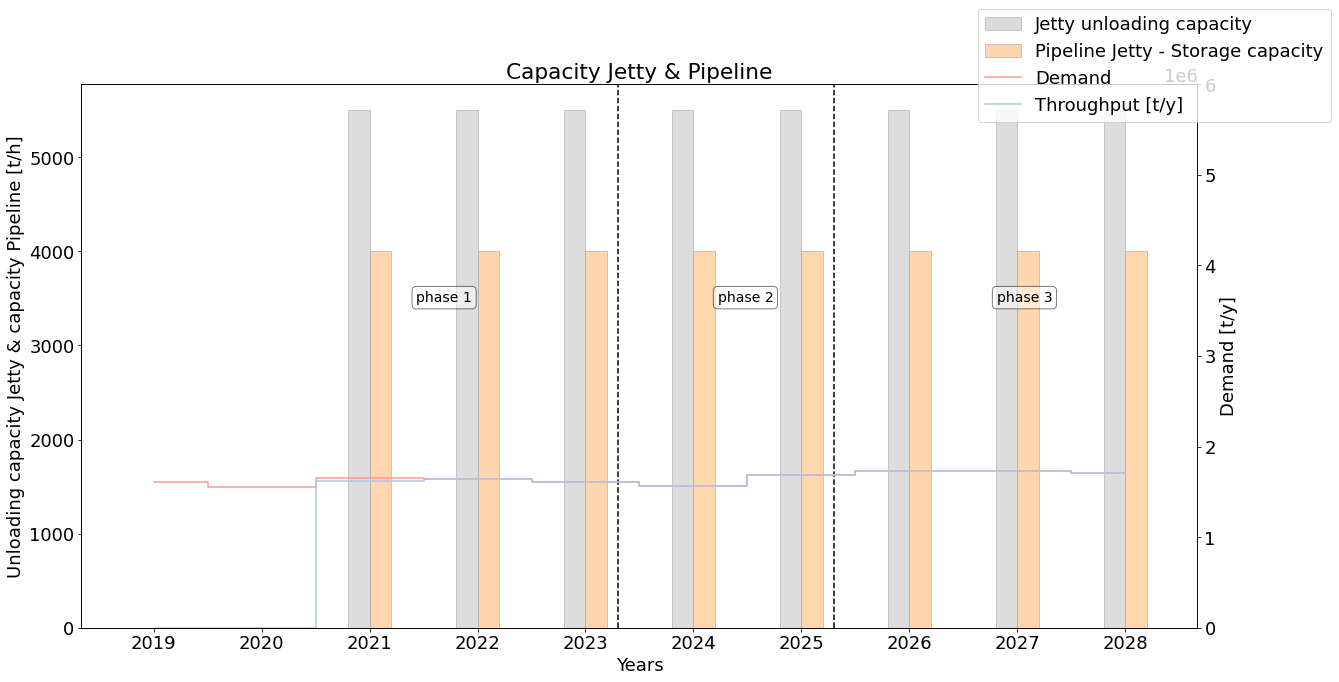

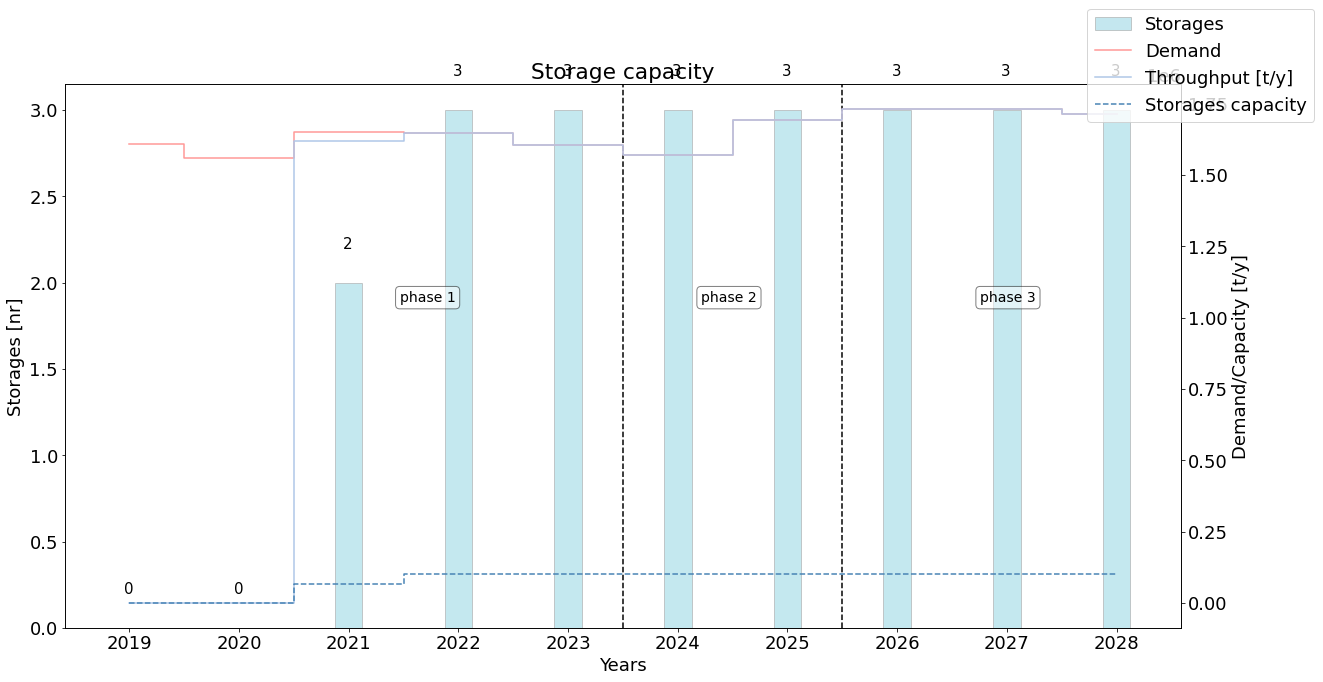

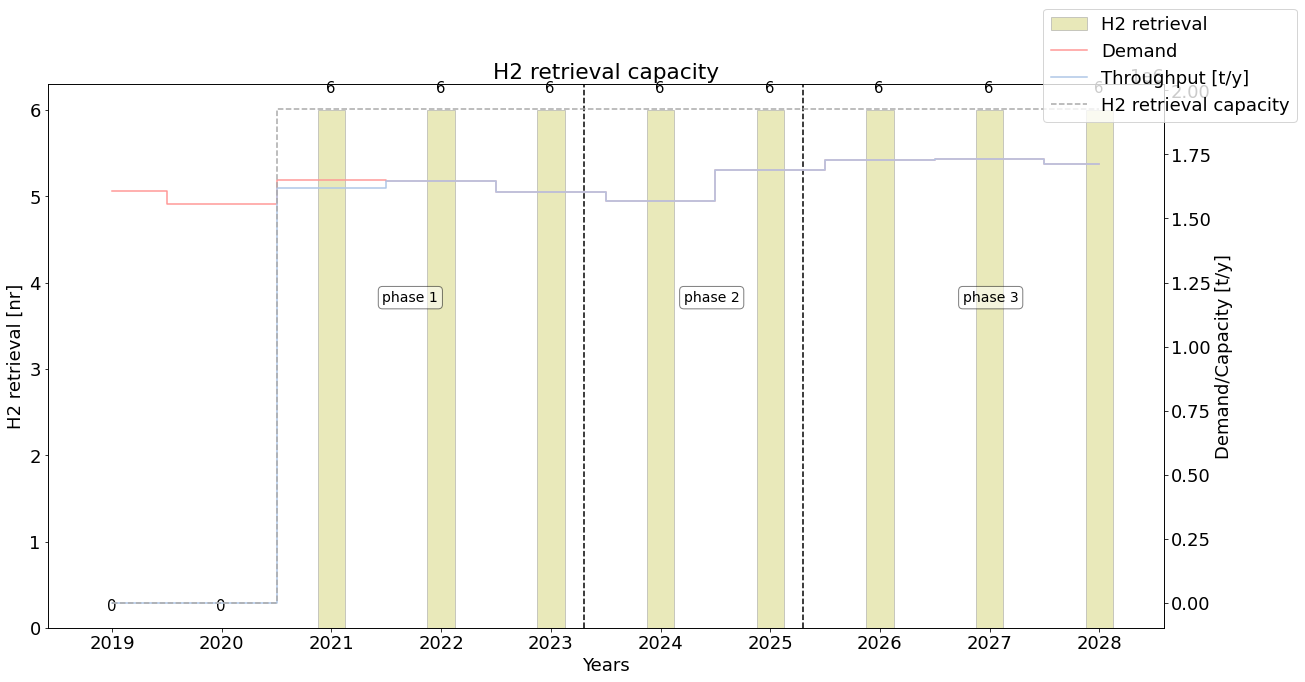

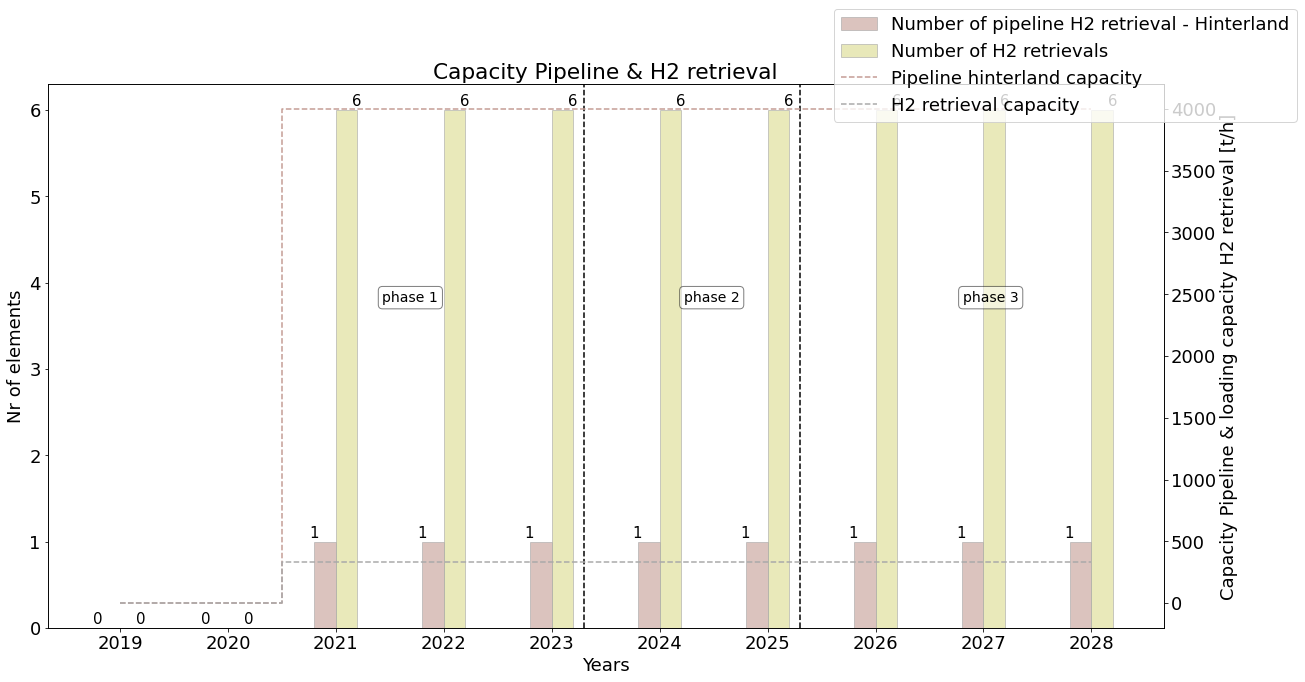

In [12]:
if True: 
    # to plot the terminal occupany's 
    Terminal.terminal_occupancy_plot() #occupancy of the berth 
    Terminal.plant_occupancy_plot() #occupancy of the plant
    
    # to plot the capacities of the different elements 
    Terminal.Jetty_capacity_plot() #jetty
    Terminal.Pipeline1_capacity_plot() #pipeline from jetty to storage
    Terminal.Storage_capacity_plot() #storage
    Terminal.H2retrieval_capacity_plot() # H2 retrieval
    Terminal.Pipeline2_capacity_plot() #pipeline from H2 retrieval to hinterland        

In [17]:
# add cash flow information for each of the Terminal elements
cash_flows, cash_flows_WACC_real = core.add_cashflow_elements(Terminal, hydrogen_objects.Labour(**hydrogen_defaults.labour_data))

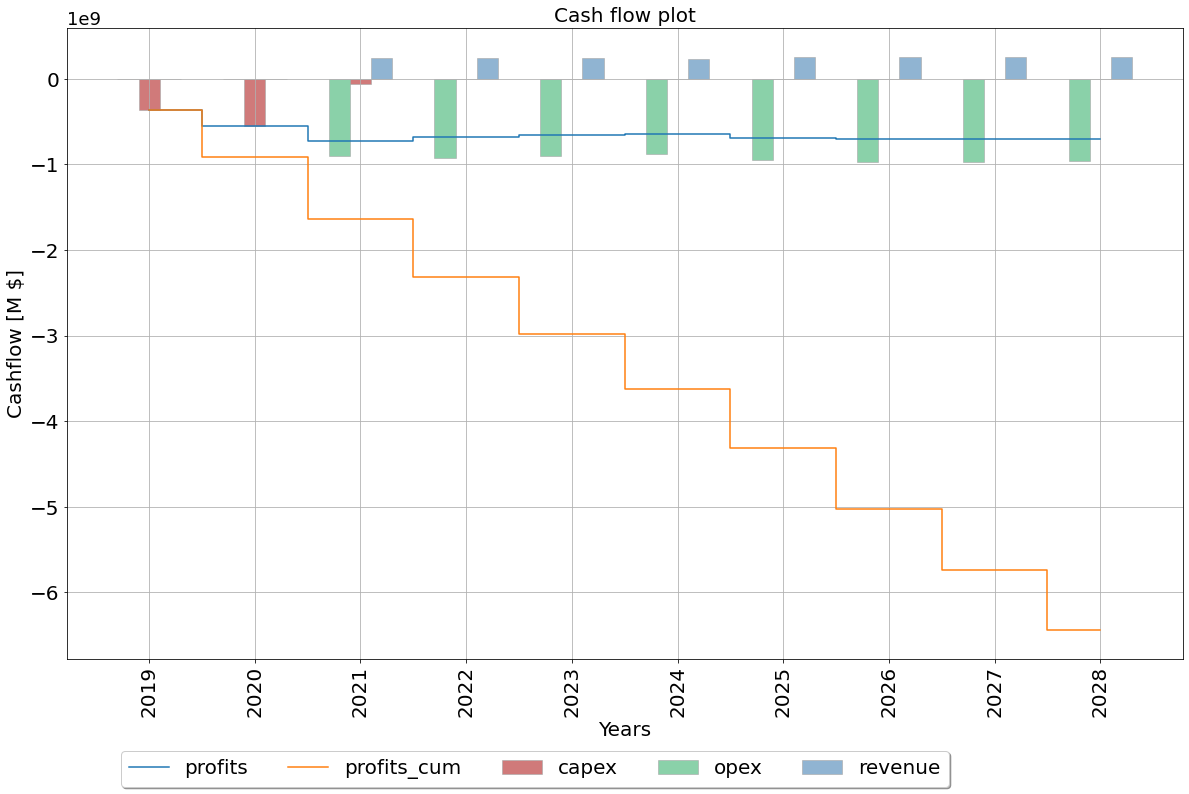

In [18]:
plot.cashflow_plot(Terminal, cash_flows, title='Cash flow plot')

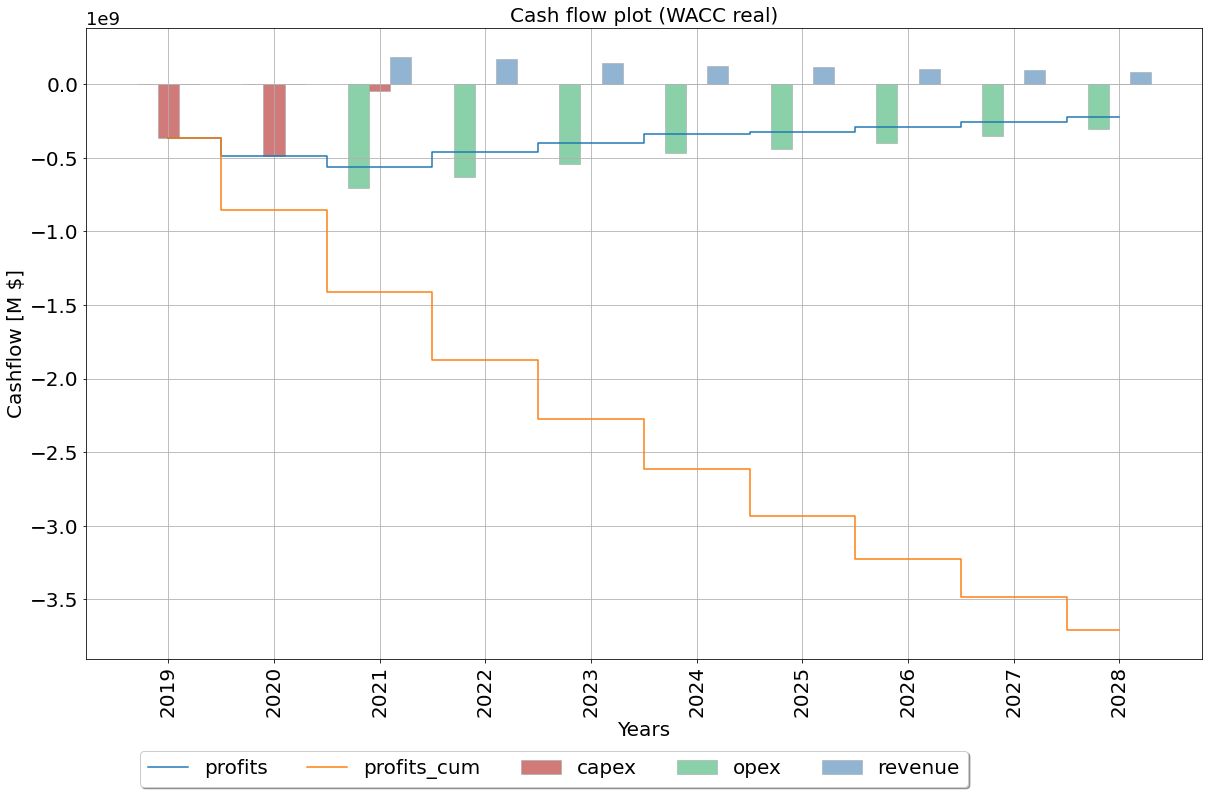

In [19]:
plot.cashflow_plot(Terminal, cash_flows_WACC_real, title='Cash flow plot (WACC real)')

In [20]:
core.NPV(Terminal, hydrogen_objects.Labour(**hydrogen_defaults.labour_data))

,CAPEX,OPEX,REVENUES,PV,cum-PV
2019,-3.633960e+08,-0.000000e+00,0.000000e+00,-3.633960e+08,-3.633960e+08
2020,-4.893288e+08,-0.000000e+00,0.000000e+00,-4.893288e+08,-8.527248e+08
2021,-4.667451e+07,-7.021485e+08,1.881538e+08,-5.606693e+08,-1.413394e+09
2022,-0.000000e+00,-6.300216e+08,1.685361e+08,-4.614855e+08,-1.874880e+09
2023,-0.000000e+00,-5.411102e+08,1.446500e+08,-3.964602e+08,-2.271340e+09
2024,-0.000000e+00,-4.660404e+08,1.245028e+08,-3.415376e+08,-2.612877e+09
2025,-0.000000e+00,-4.414647e+08,1.181800e+08,-3.232846e+08,-2.936162e+09
2026,-0.000000e+00,-3.973841e+08,1.064425e+08,-2.909416e+08,-3.227104e+09
2027,-0.000000e+00,-3.502338e+08,9.381524e+07,-2.564186e+08,-3.483522e+09
2028,-0.000000e+00,-3.053932e+08,8.178278e+07,-2.236104e+08,-3.707133e+09
